# How to Do Deep Learning on Graphs with Graph Convolutional Networks
## Part 2: Semi-Supervised Learning with Spectral Graph Convolutions
This notebook accompanies my Medium article with the above title for readers to try out and explore graph convolutional networks for themselves. You can find the article [here](https://towardsdatascience.com/how-to-do-deep-learning-on-graphs-with-graph-convolutional-networks-62acf5b143d0). To run the notebook, install the packages specified in the accompanying ```requirements.txt``` file.

#  Load Karate Club

In [1]:
from collections import namedtuple
from networkx import read_edgelist, set_node_attributes
from pandas import read_csv, Series
from numpy import array

DataSet = namedtuple(
    'DataSet',
    field_names=['X_train', 'y_train', 'X_test', 'y_test', 'network']
)

def load_karate_club():
    network = read_edgelist(
        'karate.edgelist',
        nodetype=int)

    attributes = read_csv(
        'karate.attributes.csv',
        index_col=['node'])

    for attribute in attributes.columns.values:
        set_node_attributes(
            network,
            values=Series(
                attributes[attribute],
                index=attributes.index).to_dict(),
            name=attribute
        )

    X_train, y_train = map(array, zip(*[
        ([node], data['role'] == 'Administrator')
        for node, data in network.nodes(data=True)
        if data['role'] in {'Administrator', 'Instructor'}
    ]))
    X_test, y_test = map(array, zip(*[
        ([node], data['community'] == 'Administrator')
        for node, data in network.nodes(data=True)
        if data['role'] == 'Member'
    ]))
    
    return DataSet(
        X_train, y_train,
        X_test, y_test,
        network)

In [2]:
from networkx import to_numpy_matrix, degree_centrality, betweenness_centrality, shortest_path_length
import mxnet.ndarray as nd

zkc = load_karate_club()

A = to_numpy_matrix(zkc.network)
A = nd.array(A)

X_train = zkc.X_train.flatten()
y_train = zkc.y_train
X_test = zkc.X_test.flatten()
y_test = zkc.y_test

In [9]:
display(X_train.shape, X_test.shape)
display(X_train, y_train, X_test, y_test)

(2,)

(32,)

array([ 0, 33])

array([ True, False])

array([ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31, 30,
        9, 27, 28, 32, 16, 14, 15, 18, 20, 22, 23, 25, 29, 24, 26])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False])

# Layer Implementations

In [10]:
import mxnet.ndarray as nd

In [14]:
# check * notation is dot or elements product
# it is element-wise product
a = nd.array([[1,2],[3,4]]) # 2, 2
b = nd.array([[3],[1]]) # 2, 1
display(a * b,  nd.dot(a, b))


[[3. 6.]
 [3. 4.]]
<NDArray 2x2 @cpu(0)>


[[ 5.]
 [13.]]
<NDArray 2x1 @cpu(0)>

In [15]:
from mxnet.gluon import HybridBlock
from mxnet.gluon.nn import Activation
import mxnet.ndarray as nd

class SpectralRule(HybridBlock):
    def __init__(self, A, in_units, out_units, activation='relu', **kwargs):
        super().__init__(**kwargs)
        I = nd.eye(*A.shape)
        A_hat = A.copy() + I

        D = nd.sum(A_hat, axis=0)
        D_inv = D**-0.5
        D_inv = nd.diag(D_inv)

        A_hat = D_inv * A_hat * D_inv
        
        self.in_units, self.out_units = in_units, out_units
        
        with self.name_scope():
            self.A_hat = self.params.get_constant('A_hat', A_hat)
            self.W = self.params.get(
                'W', shape=(self.in_units, self.out_units)
            )
            if activation == 'identity':
                self.activation = lambda X: X
            else:
                self.activation = Activation(activation)

    def hybrid_forward(self, F, X, A_hat, W):
        aggregate = F.dot(A_hat, X)
        propagate = self.activation(
            F.dot(aggregate, W))
        return propagate

In [16]:
class LogisticRegressor(HybridBlock):
    def __init__(self, in_units, **kwargs):
        super().__init__(**kwargs)
        with self.name_scope():
            self.w = self.params.get(
                'w', shape=(1, in_units)
            )

            self.b = self.params.get(
                'b', shape=(1, 1)
            )

    def hybrid_forward(self, F, X, w, b):
        # Change shape of b to comply with MXnet addition API
        b = F.broadcast_axis(b, axis=(0,1), size=(34, 1))
        y = F.dot(X, w, transpose_b=True) + b

        return F.sigmoid(y)

# Models

In [17]:
from mxnet.gluon.nn import HybridSequential, Activation
from mxnet.ndarray import array
from mxnet.initializer import One, Uniform, Xavier
from mxnet.gluon.loss import SigmoidBinaryCrossEntropyLoss

def build_features(A, X):
    hidden_layer_specs = [(4, 'tanh'), (2, 'tanh')] # Format: (units in layer, activation function)
    in_units = in_units=X.shape[1]
  
    features = HybridSequential()
    with features.name_scope():
        for i, (layer_size, activation_func) in enumerate(hidden_layer_specs):
            layer = SpectralRule(
                A, in_units=in_units, out_units=layer_size, 
                activation=activation_func)
            features.add(layer)

            in_units = layer_size
    return features, in_units

def build_model(A, X):
    model = HybridSequential()
    hidden_layer_specs = [(4, 'tanh'), (2, 'tanh')]
    in_units = in_units=X.shape[1]

    with model.name_scope():
        features, out_units = build_features(A, X)
        model.add(features)

        classifier = LogisticRegressor(out_units)
        model.add(classifier)

    model.hybridize()
    model.initialize(Uniform(1))

    return model, features

## Model 1: Identity Matrix as Features

In [20]:
X_1 = I = nd.eye(*A.shape)
model_1, features_1 = build_model(A, X_1)
display(model_1(X_1), X_1, A)


[[0.38453645]
 [0.38527295]
 [0.38400236]
 [0.38679546]
 [0.37862045]
 [0.37945798]
 [0.3824698 ]
 [0.37868255]
 [0.38254464]
 [0.38242218]
 [0.36589605]
 [0.36671472]
 [0.38727626]
 [0.38571015]
 [0.4009519 ]
 [0.37338603]
 [0.38278222]
 [0.3849012 ]
 [0.39297837]
 [0.38696882]
 [0.39232314]
 [0.383714  ]
 [0.378627  ]
 [0.38476542]
 [0.3708577 ]
 [0.36897758]
 [0.4104205 ]
 [0.38160273]
 [0.38839436]
 [0.3863281 ]
 [0.3924109 ]
 [0.38947552]
 [0.39556646]
 [0.37505624]]
<NDArray 34x1 @cpu(0)>


[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
<NDArray 34x34 @cpu(0)>


[[0. 1. 1. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
<NDArray 34x34 @cpu(0)>

## Model 2: Distance to Administrator and Instructor as Additional Features

* 加入兩個新的feature - 各個節點連接到Administrator以及Instructor的最短路徑長度 - 表示一種關係強度的特徵，即使我們已經有鄰接矩陣，但這樣的特徵可以幫助我們更了解各個成員距離和Adminstrator, Instructor的關係強度

In [35]:
import seaborn as sns
import matplotlib.pyplot as plot
import pandas as pd
%matplotlib inline

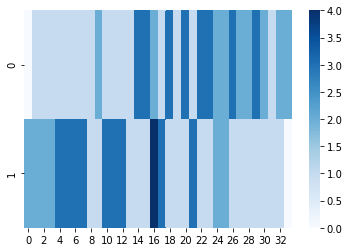

In [39]:
X_2 = nd.zeros((A.shape[0], 2))
node_distance_instructor = shortest_path_length(zkc.network, target=33)
node_distance_administrator = shortest_path_length(zkc.network, target=0)

for node in zkc.network.nodes():
    X_2[node][0] = node_distance_administrator[node]
    X_2[node][1] = node_distance_instructor[node]

df = pd.DataFrame(X_2.asnumpy())
ax = sns.heatmap(df.T,  cmap="Blues")

In [23]:
X_2 = nd.concat(X_1, X_2)
model_2, features_2 = build_model(A, X_2)
model_2(X_2)

display(model_2(X_2), X_2, A)


[[0.45630231]
 [0.4508565 ]
 [0.4515144 ]
 [0.44936156]
 [0.43585536]
 [0.44915253]
 [0.44838858]
 [0.44639355]
 [0.44689578]
 [0.44456998]
 [0.40450302]
 [0.4123596 ]
 [0.4516814 ]
 [0.40882823]
 [0.43688026]
 [0.45141783]
 [0.44660023]
 [0.4424334 ]
 [0.44739023]
 [0.44989967]
 [0.4355531 ]
 [0.45382524]
 [0.39836302]
 [0.4551535 ]
 [0.3999242 ]
 [0.4271048 ]
 [0.42709652]
 [0.43261012]
 [0.47193933]
 [0.44624743]
 [0.43878743]
 [0.44783783]
 [0.43595275]
 [0.43926147]]
<NDArray 34x1 @cpu(0)>


[[1. 0. 0. ... 0. 0. 2.]
 [0. 1. 0. ... 0. 1. 2.]
 [0. 0. 1. ... 0. 1. 2.]
 ...
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 2. 1.]
 [0. 0. 0. ... 1. 2. 0.]]
<NDArray 34x36 @cpu(0)>


[[0. 1. 1. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
<NDArray 34x34 @cpu(0)>

# Train and Test Models

In [24]:
%time
from mxnet import autograd
from mxnet.gluon import Trainer
from mxnet.ndarray import sum as ndsum
import numpy as np

def train(model, features, X, X_train, y_train, epochs):
    cross_entropy = SigmoidBinaryCrossEntropyLoss(from_sigmoid=True)
    trainer = Trainer(model.collect_params(), 'sgd', {'learning_rate': 0.001, 'momentum': 1})

    feature_representations = [features(X).asnumpy()]

    for e in range(1, epochs + 1):
        cum_loss = 0
        cum_preds = []

        for i, x in enumerate(X_train):
            y = array(y_train)[i]
            with autograd.record():
                preds = model(X)[x]
                loss = cross_entropy(preds, y)
            loss.backward()
            trainer.step(1)

            cum_loss += loss.asscalar()
            cum_preds += [preds.asscalar()]

        feature_representations.append(features(X).asnumpy())
            
        if (e % (epochs//10)) == 0:
            print(f"Epoch {e}/{epochs} -- Loss: {cum_loss: .4f}")
            print(cum_preds)
    return feature_representations

def predict(model, X, nodes):
    preds = model(X)[nodes].asnumpy().flatten()
    return np.where(preds >= 0.5, 1, 0)

CPU times: user 7 µs, sys: 2 µs, total: 9 µs
Wall time: 85.8 µs


## Performance of Model 1

In [25]:
from sklearn.metrics import classification_report

feature_representations_1 = train(model_1, features_1, X_1, X_train, y_train, epochs=5000)
y_pred_1 = predict(model_1, X_1, X_test)
print(classification_report(y_test, y_pred_1))

Epoch 500/5000 -- Loss:  0.0015
[0.99999595, 0.0014864949]
Epoch 1000/5000 -- Loss:  0.0000
[1.0, 1.1555861e-07]
Epoch 1500/5000 -- Loss:  0.0000
[1.0, 1.05360096e-11]
Epoch 2000/5000 -- Loss:  0.0000
[1.0, 9.661362e-16]
Epoch 2500/5000 -- Loss:  0.0000
[1.0, 8.864596e-20]
Epoch 3000/5000 -- Loss:  0.0000
[1.0, 8.124298e-24]
Epoch 3500/5000 -- Loss:  0.0000
[1.0, 7.4013637e-28]
Epoch 4000/5000 -- Loss:  0.0000
[1.0, 6.79103e-32]
Epoch 4500/5000 -- Loss:  0.0000
[1.0, 6.230931e-36]
Epoch 5000/5000 -- Loss:  0.0000
[1.0, 0.0]
              precision    recall  f1-score   support

       False       0.36      0.31      0.33        16
        True       0.39      0.44      0.41        16

    accuracy                           0.38        32
   macro avg       0.37      0.38      0.37        32
weighted avg       0.37      0.38      0.37        32



## Performance of Model 2

In [26]:
feature_representations_2= train(model_2, features_2, X_2, X_train, y_train, epochs=250)
y_pred_2 = predict(model_2, X_2, X_test)
print(classification_report(y_test, y_pred_2))

Epoch 25/250 -- Loss:  1.3461
[0.47373417, 0.45065102]
Epoch 50/250 -- Loss:  1.2933
[0.5145271, 0.46674407]
Epoch 75/250 -- Loss:  1.1814
[0.5619074, 0.4539177]
Epoch 100/250 -- Loss:  0.9569
[0.60607564, 0.3662827]
Epoch 125/250 -- Loss:  0.6449
[0.65918607, 0.20398323]
Epoch 150/250 -- Loss:  0.3777
[0.7428801, 0.07735302]
Epoch 175/250 -- Loss:  0.1958
[0.8446773, 0.026635718]
Epoch 200/250 -- Loss:  0.0882
[0.9248902, 0.01007265]
Epoch 225/250 -- Loss:  0.0357
[0.96906215, 0.0042475085]
Epoch 250/250 -- Loss:  0.0135
[0.9884786, 0.0019322525]
              precision    recall  f1-score   support

       False       0.62      0.94      0.75        16
        True       0.88      0.44      0.58        16

    accuracy                           0.69        32
   macro avg       0.75      0.69      0.67        32
weighted avg       0.75      0.69      0.67        32

